# Model training

In [55]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import DMatrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


from sklearn.utils import compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline



In [56]:
df_final = pd.read_csv("preprocessed_data/RestWaterRodent_data.csv.zip")

In [57]:
# Keep columns not for training as metadata
print(df_final.shape)
meta_final = df_final[['CAMIS', 'GRADE DATE', 'VIOLATION CODE','ClosestWorkingTankDate', 'ClosestBadTankDate', 'PREV_GRADE DATE', 'INSPECTION_DATE']]

# data for model training
data = df_final.drop(columns=['CAMIS', "BBL", "CRITICAL FLAG_Not Critical", 'GRADE DATE', "VIOLATION CODE", 'ClosestWorkingTankDate', 'ClosestBadTankDate', 'PREV_GRADE DATE', "Unnamed: 0"])
data.head()

(36880, 23)


,ZIPCODE,CUISINE DESCRIPTION,GRADE,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,PREV_GRADE,RECENCY,INSPECTION_DATE,RESULT
0,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,3.0,146.0,NaN,0.0
2,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,3.0,645.0,NaN,0.0
3,2.801389,2.913240,3.0,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016-09-19 15:25:51,0.0
4,2.801389,2.913240,2.0,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,3.0,885.0,2016-09-19 15:25:51,0.0


In [58]:
# train_test_split

# # 80% split in order due to time-sensitive data
# index_80 = int(data.shape[0]*0.8)
# dev = data[:index_80]
# test = data[index_80+1:]

data.loc[data['GRADE'] == 1, 'GRADE'] = 1
data.loc[data['GRADE'] == 2, "GRADE"] = 1
data.loc[data['GRADE'] == 3, "GRADE"] = 0

dev, test = train_test_split(data, test_size=0.2, random_state=42)
# train, val = train_test_split(dev, test_size=0.2, random_state=42)


dev_Y = dev["GRADE"].astype(int)
# train_Y = train["GRADE"].astype(int)
# val_Y = val["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(columns=["GRADE"])
test_X = test.drop(columns=["INSPECTION_DATE","GRADE"])

# scaling recency
scaler = StandardScaler()

dev_X["RECENCY"] = scaler.fit_transform(np.reshape(np.array(dev_X["RECENCY"]), (-1, 1)))
test_X["RECENCY"] = scaler.transform(np.reshape(np.array(test_X["RECENCY"]), (-1, 1)))


dev_X["ClosestBadTankDis"] = scaler.fit_transform(np.reshape(np.array(dev_X["ClosestBadTankDis"]), (-1, 1)))
test_X["ClosestBadTankDis"] = scaler.transform(np.reshape(np.array(test_X["ClosestBadTankDis"]), (-1, 1)))

# Maybe should drop the time-series aspect... makes sampling and validation so complicated

dev_X = dev_X.drop(columns=["PREV_GRADE", "RECENCY", "INSPECTION_DATE"])
test_X = test_X.drop(columns=["PREV_GRADE", "RECENCY"])

# Final columns to use for training:
dev_X.head()

,ZIPCODE,CUISINE DESCRIPTION,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT
26718,2.809524,2.670925,0.865329,0.905277,0.0,0.0,0.0,0.0,1.0,1.0
9667,2.671320,2.834724,0.975922,0.750115,0.0,0.0,0.0,1.0,0.0,0.0
28186,2.750765,2.714226,0.614378,-0.861601,0.0,0.0,0.0,1.0,0.0,1.0
3120,2.773779,2.834724,0.830794,-0.767697,0.0,0.0,0.0,1.0,0.0,1.0
21284,2.676289,2.819990,0.140952,0.990341,0.0,0.0,1.0,0.0,0.0,0.0


Accuracy from constant prediction model:  0.8981832971800434
Macro-F1 from constant prediction model:  0.4731804871080637


<AxesSubplot:>

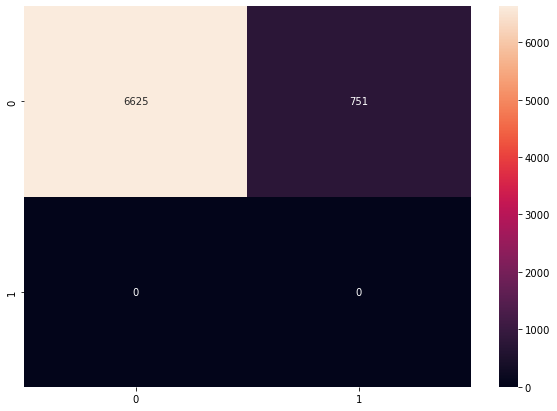

In [59]:
# Baseline model -- would just predict 3 everytime

constant_pred = np.repeat(0, test.shape[0])
base_acc = accuracy_score(constant_pred, test_Y)
# base_roc_auc = roc_auc_score(constant_pred, test_Y)
print("Accuracy from constant prediction model: ", base_acc)
print("Macro-F1 from constant prediction model: ", f1_score(test_Y, constant_pred, average="macro"))

base_conf = confusion_matrix(constant_pred, test_Y)

plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')

### SMOTE 

In [60]:
# resampling or other feature engineering techniques
# I dont think SMOTE makes sense since it will be messing with the order of the dates. Likely need to use ROS
sm = SMOTE()
dev_SMOTE = sm.fit_resample(dev_X, dev_Y)
dev_SMOTE_X = dev_SMOTE[0]
dev_SMOTE_Y = dev_SMOTE[1]

# Now, each class has even 
dev_SMOTE_Y.value_counts()

0    26507
1    26507
Name: GRADE, dtype: int64

### ROS

In [61]:
# resampling or other feature engineering techniques
ros = RandomOverSampler()
dev_ROS = ros.fit_resample(dev_X, dev_Y)
dev_ROS_X = dev_ROS[0]
dev_ROS_Y = dev_ROS[1]

# # need to rejoin them to sort by date in the dev set
dev_ROS_joined = pd.concat([dev_ROS_X, dev_ROS_Y], axis=1)
# dev_ROS_joined.sort_values("INSPECTION_DATE")

dev_ROS_Y = dev_ROS_joined[["GRADE"]]
dev_ROS_X = dev_ROS_joined.drop(columns=["GRADE", "INSPECTION_DATE"])

### Need to define our own custom scorer to get ROC_AUC for multiclass

In [62]:
# myscore = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

### Lets see how a baseline logistic regression model does on our ROS, SMOTE and class-weighting 

Log. Reg F1 score (SMOTE) 0.5002660285325131


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


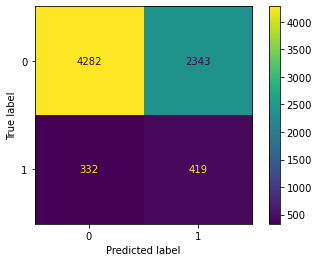

In [63]:
lr_SMOTE = LogisticRegression()
lr_SMOTE.fit(dev_SMOTE_X, dev_SMOTE_Y)
lr_SMOTE_preds = lr_SMOTE.predict(test_X)
plot_confusion_matrix(lr_SMOTE, test_X, test_Y)
# print("Log. Reg ROC AUC score (SMOTE)", myscore(lr_SMOTE, test_X, test_Y))
print("Log. Reg F1 score (SMOTE)", f1_score(test_Y, lr_SMOTE_preds, average="macro"))

Log. Reg F1 score (ROS) 0.4992784959732627


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


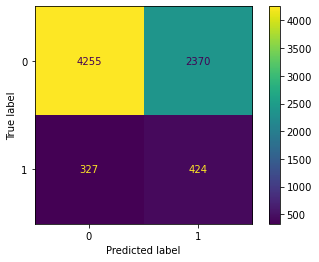

In [64]:
lr_ROS = LogisticRegression()
lr_ROS.fit(dev_ROS_X, dev_ROS_Y)
lr_ROS_preds = lr_ROS.predict(test_X)
plot_confusion_matrix(lr_ROS, test_X, test_Y)
# print("Log. Reg ROC AUC score (ROS)", myscore(lr_ROS, test_X, test_Y))
print("Log. Reg F1 score (ROS)", f1_score(test_Y, lr_ROS_preds, average="macro"))

In [65]:
# Logistic regression with class-weights

### Repeat this process for Random Forest

Rand. Forest F1 score (SMOTE) 0.5640352959325733


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


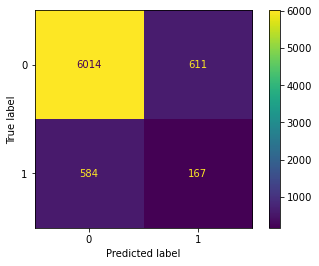

In [66]:
rf_SMOTE = RandomForestClassifier()
rf_SMOTE.fit(dev_SMOTE_X, dev_SMOTE_Y)
rf_SMOTE_preds = rf_SMOTE.predict(test_X)

plot_confusion_matrix(rf_SMOTE, test_X, test_Y)
# print("Rand. Forest Multi Class ROC AUC score (SMOTE)", myscore(rf_SMOTE, test_X, test_Y))
print("Rand. Forest F1 score (SMOTE)", f1_score(test_Y, rf_SMOTE_preds, average="macro"))

Rand. Forest F1 score (ROS) 0.5667351900833476


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


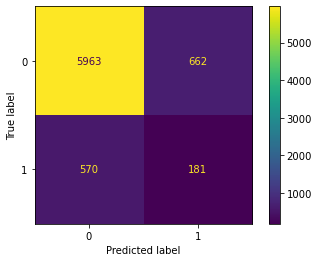

In [67]:
rf_ROS = RandomForestClassifier()
rf_ROS.fit(dev_ROS_X, dev_ROS_Y)
rf_ROS_preds = rf_ROS.predict(test_X)

plot_confusion_matrix(rf_ROS, test_X, test_Y)
# print("Rand. Forest Multi Class ROC AUC score (ROS)", myscore(rf_ROS, test_X, test_Y))
print("Rand. Forest F1 score (ROS)", f1_score(test_Y, rf_ROS_preds, average="macro"))

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Rand. Forest F1 score (Weighted) 0.5723097877044245


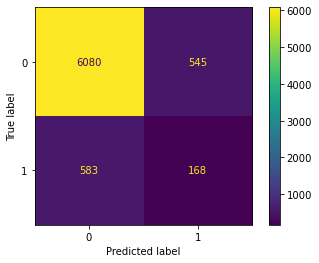

In [68]:
rf_weighted = RandomForestClassifier(class_weight="balanced")
rf_weighted.fit(dev_X, dev_Y)
rf_weighted_preds = rf_weighted.predict(test_X)

plot_confusion_matrix(rf_weighted, test_X, test_Y)
# print("Rand. Forest Multi Class ROC AUC score (Class-Weighted)", myscore(rf_weighted, test_X, test_Y))
print("Rand. Forest F1 score (Weighted)", f1_score(test_Y, rf_weighted_preds, average="macro"))

### Lets see how a baseline XGBoost model does on our SMOTE and ROS data

[15:56:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoost F1 score (SMOTE) 0.5504222384719022


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


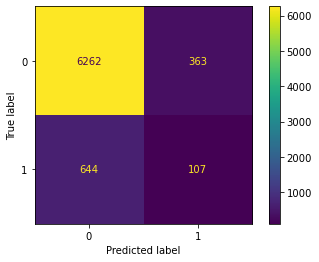

In [69]:
xg_SMOTE = XGBClassifier(use_label_encoder=False)
xg_SMOTE.fit(dev_SMOTE_X, dev_SMOTE_Y)
xg_SMOTE_preds = xg_SMOTE.predict(test_X)

plot_confusion_matrix(xg_SMOTE, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (SMOTE)", myscore(xg_SMOTE, test_X, test_Y))
print("XGBoost F1 score (SMOTE)", f1_score(test_Y, xg_SMOTE_preds, average="macro"))

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost F1 score (ROS) 0.5307629415277203


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


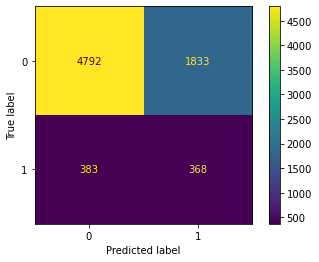

In [70]:
xg_ROS = XGBClassifier(use_label_encoder=False)
xg_ROS.fit(dev_ROS_X, dev_ROS_Y)
xg_ROS_preds = xg_ROS.predict(test_X)

plot_confusion_matrix(xg_ROS, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (ROS)", myscore(xg_ROS, test_X, test_Y))
print("XGBoost F1 score (ROS)", f1_score(test_Y, xg_ROS_preds, average="macro"))

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost F1 score (Weighted) 0.5231467422473914


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


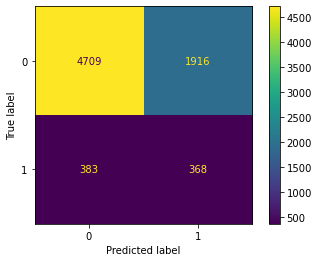

In [71]:
# XG Boost with class weights
from sklearn.utils import class_weight

xg_weighted = XGBClassifier(use_label_encoder=False)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=dev_Y
)


xg_weighted.fit(dev_X, dev_Y, sample_weight=classes_weights)
xg_weighted_preds = xg_weighted.predict(test_X)

plot_confusion_matrix(xg_weighted, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (Class-Weighted)", myscore(xg_weighted, test_X, test_Y))
print("XGBoost F1 score (Weighted)", f1_score(test_Y, xg_weighted_preds, average="macro"))

Ok, seems like the out-of-the-box Linear Regression classifier is doing better, still a good degree of issues due to the unbalanced dataset. Lets see if with some tuning, we can get better!

### XG Boost with SMOTE - Tuning

In [72]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xg_boost_grid_params = {'n_estimators': [200, 300, 400], 'learning_rate': [0.001, 0.01, 0.3, 0.5], 'max_depth': [4, 6, 8]}
myscore = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="f1_macro", verbose=5, n_iter=10)
grid.fit(dev_SMOTE_X, dev_SMOTE_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with SMOTE were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.658 total time=   2.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.729 total time=   2.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.724 total time=   2.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.747 total time=   2.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.732 total time=   2.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=0.748 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=0.940 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=0.936 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=0.942 total time=   4.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=0.936 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.725 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.924 total time=   3.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.924 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.930 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.926 total time=   4.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.691 total time=   8.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.829 total time=   8.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.818 total time=   8.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.832 total time=   8.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.840 total time=   8.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.001, max_depth=6, n_estimators=200;, score=0.652 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.001, max_depth=6, n_estimators=200;, score=0.765 total time=   4.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.001, max_depth=6, n_estimators=200;, score=0.742 total time=   5.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.001, max_depth=6, n_estimators=200;, score=0.750 total time=   4.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.001, max_depth=6, n_estimators=200;, score=0.751 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.5, max_depth=4, n_estimators=400;, score=0.734 total time=   5.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.5, max_depth=4, n_estimators=400;, score=0.928 total time=   5.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.5, max_depth=4, n_estimators=400;, score=0.930 total time=   5.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.5, max_depth=4, n_estimators=400;, score=0.933 total time=   5.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.5, max_depth=4, n_estimators=400;, score=0.931 total time=   5.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=300;, score=0.698 total time=   8.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=300;, score=0.854 total time=   8.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=300;, score=0.846 total time=   8.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=300;, score=0.854 total time=   8.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=300;, score=0.851 total time=   8.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=200;, score=0.694 total time=   5.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=200;, score=0.833 total time=   5.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=200;, score=0.833 total time=   5.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=200;, score=0.832 total time=   5.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=200;, score=0.833 total time=   6.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=400;, score=0.702 total time=  11.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=400;, score=0.865 total time=  11.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=400;, score=0.858 total time=  11.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=400;, score=0.864 total time=  11.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=400;, score=0.864 total time=  11.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=400;, score=0.627 total time=   5.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=400;, score=0.688 total time=   5.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=400;, score=0.685 total time=   5.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=400;, score=0.690 total time=   5.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.001, max_depth=4, n_estimators=400;, score=0.683 total time=   5.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


 Using a random search, the optimal parameters for the XG Boost Tree with SMOTE were found to be {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.5}, with a top val score of 0.9002767786028087


In [75]:
optimal_SMOTE_xg = XGBClassifier(eta = 0.5, max_depth = 6, n_estimators= 200, use_label_encoder=False, eval_metric="mlogloss")
optimal_SMOTE_xg.fit(dev_SMOTE_X, dev_SMOTE_Y)
optimal_SMOTE_xg_preds = optimal_SMOTE_xg.predict(test_X)
print("Tuned XG Boost F-1 Score: ", f1_score(test_Y, optimal_SMOTE_xg_preds, average="macro"))

plot_confusion_matrix(optimal_SMOTE_xg, test_X, test_Y)
plot_importance(optimal_SMOTE_xg)
plot_confusion_matrix(optimal_SMOTE_xg, dev_SMOTE_X, dev_SMOTE_Y)

SyntaxError: invalid syntax (3316339692.py, line 3)

### Linear Reg. with SMOTE - Tuning

Need to do time-series specific splits for the cross validation

In [74]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

tscv = TimeSeriesSplit(n_splits = 4)
rmse = []

for train_index, test_index in tscv.split(dev_ROS_joined):
    print(train_index)
    print(test_index)

    cv_train, cv_val = dev_ROS_joined.iloc[train_index], dev_ROS_joined.iloc[test_index]

    
    # arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
    # predictions = arma.predict(cv_val.index.values[0], cv_val.index.values[-1])
    # true_values = cv_val.values
    # # rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
print("RMSE: {}".format(np.mean(rmse)))

NameError: name 'dev_ROS_joined' is not defined

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

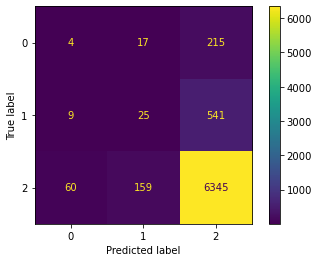

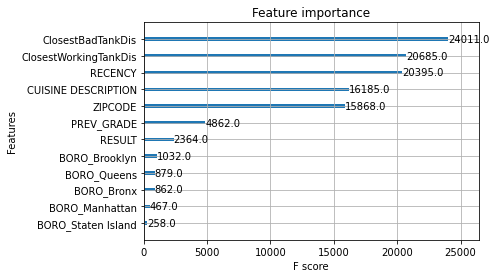

In [ ]:
optimal_SMOTE_xg = XGBClassifier(eta = 0.3, max_depth = 8, n_estimators= 400, use_label_encoder=False, eval_metric="mlogloss")
optimal_SMOTE_xg.fit(dev_SMOTE_X, dev_SMOTE_Y)
preds = optimal_SMOTE_xg.predict(test_X)
plot_confusion_matrix(optimal_SMOTE_xg, test_X, test_Y)
plot_importance(optimal_SMOTE_xg)

### Class-Weighted XG Boost

In [ ]:
# adding class weights:
class_weights = compute_sample_weight('balanced',dev_Y)

xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xg_boost_model.fit(dev_X, dev_Y, sample_weight=class_weights)
xg_boost_grid_params = {'n_estimators': [200, 300, 400], 'learning_rate': [0.05, 0.1, 0.3], 'max_depth': [4, 6, 8]}
myscore = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

# # Fit the random search model
grid = GridSearchCV(estimator=xg_boost_model, param_grid=xg_boost_grid_params, cv=3, scoring=myscore, verbose=1)
grid.fit(dev_X, dev_Y, sample_weight=class_weights)
print(f" Using a random search, the optimal parameters for the random forest were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

[0.37102149 0.37102149 0.37102149 ... 0.37102149 0.37102149 4.37679869]
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

 Using a random search, the optimal parameters for the random forest were found to be {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}, with a top val score of 0.6393679442524595


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:33:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

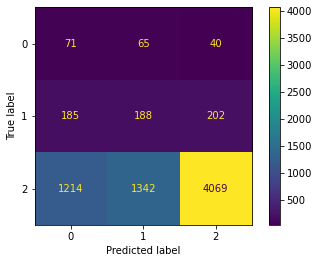

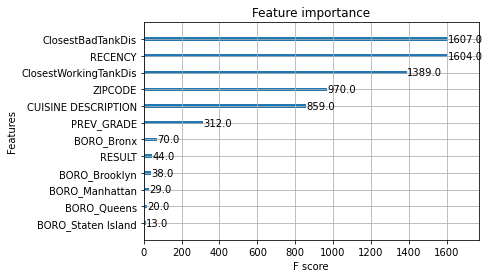

In [ ]:
optimal_weighted_xg = XGBClassifier(eta = 0.05, max_depth = 4, n_estimators= 200)
optimal_weighted_xg.fit(dev_X, dev_Y, sample_weight=class_weights)
preds = optimal_weighted_xg.predict(test_X)
# xg_weighted_acc = roc_auc_score(test_Y, preds)
# print("ROC AUC from weighted XG Boost:", xg_weighted_acc)
plot_confusion_matrix(optimal_weighted_xg, test_X, test_Y)
plot_importance(optimal_weighted_xg)

In [ ]:
# visualizations